### Mod2Mod

We explore using deep learning to learn mappings from one satellite imaging modality to another.

* Some modalitities are expensive to obtain, or not available at the needed time.
* Some modalitities are more intrerpretable to the untrained eye
* Some algorithms require having specific bands, or they are trained on specific bands and we would like to achieve a similar performance on new bands

This technique is called Colorification (used for converting grayscale to RGB images, but here we consider the more general case of mapping). It can be achieved by fitting a function from one modality to the other one and when a lot of data is available can be tackled by deep learning.

https://arxiv.org/pdf/1604.02245.pdf

https://richzhang.github.io/colorization/


We will explore several modalities: RGB, Infrared, Radar.

### RGB2IR

We will use a small image from Planet Labs RGB-IR image to test the pipeline.

In [104]:
# !pip install scikit-image

In [117]:
# read the image
import skimage

im = skimage.io.imread('../input/planet-image/1057916_2016-07-07_RE1_3A_Visual_clip.tif')

In [118]:
im = im[:1536,:1536,:]

In [119]:
#plt.imshow(im[:,:,7],cmap = 'gray')

In [120]:
# reading an sentinel1&sentinel2 image combo extracted from Google Earth Engine
#im = skimage.io.imread('../input/ls-yakima/LS_Yakima_20180811.tif')

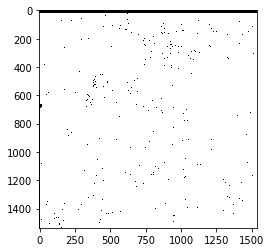

In [121]:
plt.imshow(im[:,:,3],cmap = 'gray')

In [194]:
from skimage.util.shape import view_as_blocks
im_blocks = view_as_blocks(im, block_shape=(128, 128, 4))

/opt/conda/lib/python3.6/site-packages/skimage/util/shape.py:93: RuntimeWarning: Cannot provide views on a non-contiguous input array without copying.
  warn(RuntimeWarning("Cannot provide views on a non-contiguous input "


In [195]:
# splitting into tiles
im_blocks.shape


(12, 12, 1, 128, 128, 4)

![](http://)We will use Keras and a deep learning architecture called [U-net](https://arxiv.org/abs/1505.04597) (which has been successful in many imaging domains).

In [196]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
TRAIN_PATH = '../input/stage1_train/'
TEST_PATH = '../input/stage1_test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

(array([  48874., 2310422.]),
 array([  0. , 127.5, 255. ]),
 <a list of 2 Patch objects>)

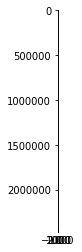

In [197]:
import matplotlib.pyplot as plt
plt.imshow(im[:,:,3],cmap = 'gray')
plt.hist(im[:,:,3].ravel(),2)

In [198]:
imsize = 128

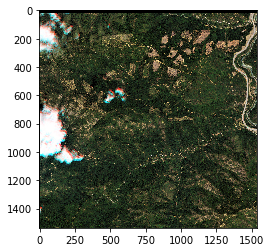

In [199]:
plt.imshow(im[:,:,:3])

In [200]:
im_blocks.squeeze().shape

(12, 12, 128, 128, 4)

In [201]:
im_blocks = im_blocks.squeeze().reshape((12*12,128,128,4))
im_blocks.shape

(144, 128, 128, 4)

In [202]:
#X_train = im_blocks[:8,:,:,:3] 
#Y_train = im_blocks[:8,:,:,-1]
#X_test = im_blocks[8:,:,:,:3]
#Y_test = im_blocks[8:,:,:,-1]

In [203]:
im_blocks.shape

(144, 128, 128, 4)

In [204]:
from sklearn.model_selection import train_test_split

In [211]:
im_blocks[:,:,:,3].reshape(dim[0],dim[1],dim[2],1).shape

(144, 128, 128, 1)

In [216]:
# we will randomly split
X_train, X_test, Y_train, Y_test = train_test_split(im_blocks[:,:,:,:3], im_blocks[:,:,:,:3].mean(axis=3), test_size=0.33, random_state=42)

In [217]:
Y_train.shape

(96, 128, 128)

In [219]:
Y_train = Y_train.reshape(Y_train.shape[0],128,128,1)
Y_test = Y_test.reshape(Y_test.shape[0],128,128,1)

Let's see if things look all right by drawing some random images and their associated masks.

# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

In [220]:

#Y_train = Y_train.reshape(Y_train.shape[0]*Y_train.shape[1],imsize,imsize,1)

In [221]:
#X_train = X_train.reshape((12*12,128,128,3))
#print(X_train.shape)
#Y_train = Y_train.reshape((12*12,128,128,1))
#print(Y_train.shape)

In [222]:
Y_test.min()

0.0

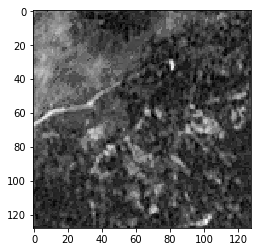

In [223]:
# Check if training data looks all right
ix = random.randint(0, len(im_blocks))
plt.imshow(X_train[0,:,:,0],)
plt.imshow(Y_train[0,:,:,0],cmap = 'gray')

We are going to 



In [224]:
# Define IoU metric
# def mean_iou(y_true, y_pred):
#    prec = []
#    for t in np.arange(0.5, 1.0, 0.05):
#        y_pred_ = tf.to_int32(y_pred > t)
#        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
#        K.get_session().run(tf.local_variables_initializer())
#        with tf.control_dependencies([up_opt]):
#            score = tf.identity(score)
#        prec.append(score)
#    return K.mean(K.stack(prec), axis=0)

# Build and train our neural network
Next we build our U-Net model, loosely based on [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/pdf/1505.04597.pdf) and very similar to [this repo](https://github.com/jocicmarko/ultrasound-nerve-segmentation) from the Kaggle Ultrasound Nerve Segmentation competition.

![](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

In [225]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='linear') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, 128, 128, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_58 (Conv2D)              (None, 128, 128, 16) 448         lambda_4[0][0]                   
__________________________________________________________________________________________________
dropout_28 (Dropout)            (None, 128, 128, 16) 0           conv2d_58[0][0]                  
__________________________________________________________________________________________________
conv2d_59 

*Update: Changed to ELU units, added dropout.*

Next we fit the model on the training data, using a validation split of 0.1. We use a small batch size because we have so little data. I recommend using checkpointing and early stopping when training your model. I won't do it here to make things a bit more reproducible (although it's very likely that your results will be different anyway). I'll just train for 10 epochs, which takes around 10 minutes in the Kaggle kernel with the current parameters. 

*Update: Added early stopping and checkpointing and increased to 30 epochs.*

In [226]:
# Fit model
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-1.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50, 
                    callbacks=[earlystopper, checkpointer])

Train on 86 samples, validate on 10 samples
Epoch 1/50
86/86 [==============================] - 2s 27ms/step - loss: 3468.9973 - val_loss: 3308.6792

Epoch 00001: val_loss improved from inf to 3308.67920, saving model to model-dsbowl2018-1.h5
Epoch 2/50
86/86 [==============================] - 0s 2ms/step - loss: 3145.9061 - val_loss: 2169.2822

Epoch 00002: val_loss improved from 3308.67920 to 2169.28223, saving model to model-dsbowl2018-1.h5
Epoch 3/50
86/86 [==============================] - 0s 2ms/step - loss: 1662.0948 - val_loss: 1139.1506

Epoch 00003: val_loss improved from 2169.28223 to 1139.15063, saving model to model-dsbowl2018-1.h5
Epoch 4/50
86/86 [==============================] - 0s 2ms/step - loss: 981.2982 - val_loss: 752.9993

Epoch 00004: val_loss improved from 1139.15063 to 752.99933, saving model to model-dsbowl2018-1.h5
Epoch 5/50
86/86 [==============================] - 0s 2ms/step - loss: 792.2771 - val_loss: 1174.9875

Epoch 00005: val_loss did not improve fro

Epoch 45/50
86/86 [==============================] - 0s 2ms/step - loss: 122.2909 - val_loss: 119.7456

Epoch 00045: val_loss improved from 122.46600 to 119.74563, saving model to model-dsbowl2018-1.h5
Epoch 46/50
86/86 [==============================] - 0s 2ms/step - loss: 119.4916 - val_loss: 114.3912

Epoch 00046: val_loss improved from 119.74563 to 114.39117, saving model to model-dsbowl2018-1.h5
Epoch 47/50
86/86 [==============================] - 0s 2ms/step - loss: 116.5068 - val_loss: 110.0002

Epoch 00047: val_loss improved from 114.39117 to 110.00022, saving model to model-dsbowl2018-1.h5
Epoch 48/50
86/86 [==============================] - 0s 2ms/step - loss: 113.7610 - val_loss: 107.6904

Epoch 00048: val_loss improved from 110.00022 to 107.69043, saving model to model-dsbowl2018-1.h5
Epoch 49/50
86/86 [==============================] - 0s 2ms/step - loss: 110.8749 - val_loss: 106.2631

Epoch 00049: val_loss improved from 107.69043 to 106.26311, saving model to model-dsbowl

All right, looks good! Loss seems to be a bit erratic, though. I'll leave it to you to improve the model architecture and parameters! 

# Make predictions

Let's make predictions both on the test set, the val set and the train set (as a sanity check). Remember to load the best saved model if you've used early stopping and checkpointing.

In [228]:
# Predict on train, val and test
model = load_model('model-dsbowl2018-1.h5')
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

48/48 [==============================] - 0s 565us/step


NameError: name 'sizes_test' is not defined

In [ ]:
# Perform a sanity check on some random training samples
ix = random.randint(0, X_train.shape[0])
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]),cmap = 'gray')
plt.show()
imshow(np.squeeze(preds_train[ix]),cmap = 'gray')
plt.show()

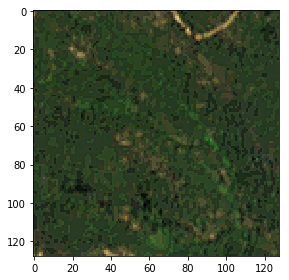

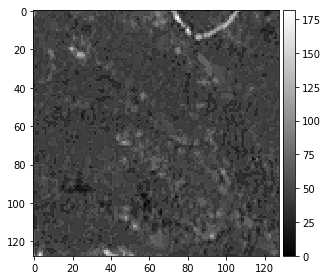

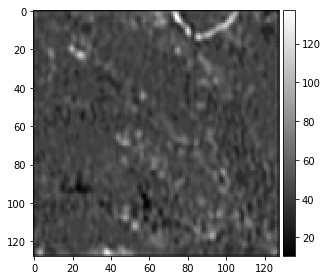

In [231]:
# Perform a sanity check on some random training samples
ix = random.randint(0, X_train.shape[0])
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]),cmap = 'gray')
plt.show()
imshow(np.squeeze(preds_train[ix]),cmap = 'gray')
plt.show()

In [ ]:
preds_train.min()

The model is at least able to fit to the training data! Certainly a lot of room for improvement even here, but a decent start. How about the validation data?

In [230]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, preds_val.shape[0])
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]),cmap = 'gray')
plt.show()
imshow(np.squeeze(preds_val[ix]),cmap = 'gray')
plt.show()

IndexError: index 10 is out of bounds for axis 0 with size 10

In [ ]:
### Future:
    

### Future:
    * test with an model pretrained on satellite imagery
    * test rural vs urban
    * 